# Machine Learning: Exercise session 06

In this exercise session we will focus on Logistic regression and decision trees.

In the first problem, we will consider the [ionosphere dataset](https://www.openml.org/d/59) and fit different logistic regression models.
The goal is to predict whether a given radar signal from the ionosphere is "good" or "bad" based on 34 predictors.

In the second problem, we will focus on decision trees.

In the third problem, we will derive the log-likelihood function for logistic regression.

**Note:** the third problem is theoretical and __not__ needed for the hand in.

In [1]:
# Import modules for feature engineering and modelling
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.metrics import accuracy_score
# Import package/module for data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

## Problem 1

* Import the dataset `ionosphere.csv`, separate the predictors and the target variable and split it into training and test set. When you perform the splitting, set `random_state=12` and `test_size=151`.

In [3]:
df=pd.read_csv("ionosphere.csv")
df[df.isna().any(axis=1)]
df

FileNotFoundError: ignored

In [ ]:
X= df.drop('class',axis=1).copy()
Y = (df['class'] == 'g').astype(int)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=151, random_state=12)


* Define a `Pipeline` where you apply the `StandardScaler` and then fit a `LogisticRegression` with the following tuning parameters: `penalty="none"`, `solver="saga"`, `tol=0.1`, `random_state=10`. Call the pipeline `pipe_logistic`.

In [ ]:
reg=LogisticRegression(penalty = "none", solver = "saga", tol =0.1, random_state=10)
scaler = StandardScaler()


pipe_logistic = Pipeline(
    [("scaler", scaler), ("reg",reg )]
)

* Fit the pipeline to the training data and predict the accuracy on the training and test dataset.

In [ ]:
pipe_logistic.fit(X_train,Y_train)


# Predict on training data
Y_train_pred = pipe_logistic.predict(X_train)
acc_train = accuracy_score(Y_train, Y_train_pred)
print("Log --- Accuracy on training data:", np.round(acc_train, 3))

# Predict on test data
Y_test_pred = pipe_logistic.predict(X_test)
acc_test = accuracy_score(Y_test, Y_test_pred)
print("Log --- Accuracy on test data:", np.round(acc_test, 3))




Log --- Accuracy on training data: 0.895
Log --- Accuracy on test data: 0.861


We now want to fit a logistic regression with the lasso penalty. To do that we need to choose the best regulatization parameter. 

* Define a `Kfold` object with 10 splits, and `random_state=919`. Remeber to shuffle the rows. Name the object `folds`.

In [ ]:
folds=KFold(n_splits=10, shuffle=True, random_state=919)

* Define a `Pipeline` where you first apply the `StandardScaler` (name this step `"scaler"`) and then fit a `LogisticRegression` (name this step `"logistic"`) with the following tuning parameters: `C=1`, `penalty="l1"`, `solver="saga"`, `tol=0.1`, `random_state=10`. Name the pipeline `pipe_logistic_l1`. What is the role of `C`? How does it compare to the tuning parameter `alpha` from `Lasso`? 

*C is the inverse of the egularization strength. So the inverse of alpha. Smaller value of C describe a stronger penalty term.* 

In [ ]:
reg2=LogisticRegression(C = 1, penalty = "l1", solver = "saga", tol = 0.1, random_state = 10)
pipe_logistic_l1= Pipeline(
    [("scaler",scaler), ("logistic",reg2)]
)

* Define now a `GridSearchCV` object to perform the cross-validation over a grid of different values for `C`. Fill in the `??`.

_Hint_: Choose carefully your grid, by trying out different possibility and looking at the cross-validated accuracy plot (see below). Ideally, you want a grid around the values of `C` that are "interesting".

In [ ]:
# Define CV object
grid = 10 ** np.linspace(-1.8, 0, num = 100)
logistic_l1_cv = GridSearchCV(
    estimator=pipe_logistic_l1,
    param_grid={"logistic__C": grid},
    scoring="accuracy",
    cv=folds,
)

* Perform the cross-validation on the training data.

In [ ]:
logistic_l1_cv.fit(X_train,Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=919, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(C=1, penalty='l1',
                                                           random_state=10,
                                                           solver='saga',
                                                           tol=0.1))]),
             param_grid={'logistic__C': array([0.01584893, 0.01652654, 0.01723311, 0.01796989, 0.01873817,
       0.0195393 , 0.02037469, 0.02124578, 0.02215412, 0.0231013 ,...
       0.24088967, 0.25118864, 0.26192793, 0.27312637, 0.28480359,
       0.29698005, 0.3096771 , 0.322917  , 0.33672296, 0.35111917,
       0.36613088, 0.3817844 , 0.39810717, 0.4151278 , 0.43287613,
       0.45138327, 0.47068166, 0.49080513, 0.51178896, 0.53366992,
       0.55648639, 0.58027834, 0.6050875 , 0.63095734, 0.65793322,

* Plot the results of the cross-validation by filling in the `??`.

_Note_: Notice that we want to compute the best model according to the __1-se rule__. To do that, we need to compute the standard error of the __mean__ cross-validated accuracy. This is obtained by dividing the standard deviations by the square root of $K = 10$ (i.e., number of folds).

In [ ]:
# Plot results of cross-validation
cv_res = logistic_l1_cv

mean_scores = cv_res.cv_results_["mean_test_score"]
se_scores = cv_res.cv_results_["std_test_score"] / np.sqrt(10) # ! very important to divide by sqrt(# folds)
params = cv_res.cv_results_['param_logistic__C']

best_index = np.argmax(mean_scores)

In [ ]:

one_se_best_param = np.min(
    grid[mean_scores > mean_scores[best_index] - se_scores[best_index]]
)

one_se_score = mean_scores[grid == one_se_best_param][0]


In [ ]:

# just for reference, we also plot the parameter that maximizes the cross-validated accuracy
best_param = cv_res.best_params_["logistic__C"] 
best_score = cv_res.best_score_


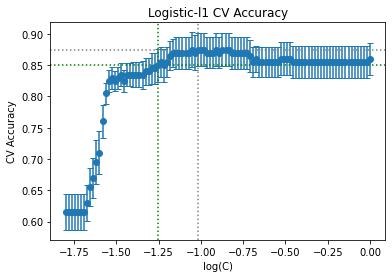

In [ ]:

plt.errorbar(x=np.log10(grid), y=mean_scores, yerr=se_scores, fmt="o", capsize=3)

plt.axvline(
    np.log10(best_param), ls="dotted", color="grey"
)  # vertical line at the parameter value yielding highest accuracty
plt.axhline(
    best_score, ls="dotted", color="grey"
)  # horizontal line at highest accuracy
plt.axvline(
    np.log10(one_se_best_param), ls="dotted", color="green"
)  # vertical line at the parameter corresponding to 1-se
plt.axhline(
    one_se_score, ls="dotted", color="green"
)  # horizontal line at corresponding to 1-se parameter

plt.title("Logistic-l1 CV Accuracy")
plt.xlabel("log(C)")
plt.ylabel("CV Accuracy")
plt.show()

* Finally, refit the __1-se rule__ model to the whole training dataset, and compute the accuracy on the training and test dataset.

In [ ]:
reg_final=LogisticRegression(penalty = 'none', solver = "saga", tol = 0.1, random_state = 10)
reg_final.fit(X_train,Y_train)

# accuracy = 1-sum(abs(Y_test - reg_final.predict(X_test)))/len(Y_test)
accuracy_reg_final = accuracy_score(Y_test, reg_final.predict(X_test))


In [ ]:
reg_final_regu=LogisticRegression(C = one_se_best_param)
reg_final_regu.fit(X_train,Y_train)

# accuracy = 1-sum(abs(Y_test - reg_final.predict(X_test)))/len(Y_test)
accuracy_reg_final_regu = accuracy_score(Y_test, reg_final_regu.predict(X_test))

* Does this model perform better than the unregularized logistic regression? What are the advantages of this model?

In [ ]:
print("unregularized reggresion :", accuracy_reg_final)
print("one se reggresion :", accuracy_reg_final_regu)

unregularized reggresion : 0.8410596026490066
one se reggresion : 0.8609271523178808


*the one se reggresion performs better. The advantage is that we have lower variance between samples than with unregularized reggresion.*

## Problem 2

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

### 2.0 Data import and Cleaning

Import the "Heart" dataset, containing demographic and medical informations about a list of patients. Drop `NA` values, convert the categorical variables into the desired pandas type: "category", and perform any other necessary data cleaning.

In [ ]:
df=pd.read_csv("Heart_ISL.csv")
df=df.dropna()

In [ ]:
df=df.drop("Unnamed: 0", axis=1)


In [ ]:
def change_to_cat(my_df,threshold = 5):
    '''
    function that takes a dataframe and an integer
    and outputs a two-list containging:
    a copy of the dataframe with column types changed to "category" if the amount of different values is lower or equal to the integer
    a dataframe containing all the unique values from original dataframe
    '''
    temp_df = my_df.copy()
    
    #creation of copy with types changed to "category"
    cat_var = [col for col in temp_df.columns if len(temp_df[col].unique()) <=threshold]  
    temp_df[cat_var]=temp_df[cat_var].astype("category")

    #creation of the df with unique values only
    temp_df_unique = pd.DataFrame.from_dict({var : list(temp_df[var].unique()) for var in cat_var}, orient='index').T
    return [temp_df,temp_df_unique]

In [ ]:
df_clean, df_categories = change_to_cat(df,5)
df_clean.dtypes

Age             int64
Sex          category
ChestPain    category
RestBP          int64
Chol            int64
Fbs          category
RestECG      category
MaxHR           int64
ExAng        category
Oldpeak       float64
Slope        category
Ca           category
Thal         category
AHD          category
dtype: object

*The conversion into categorical data seems correct*

In [ ]:
df_categories

,Sex,ChestPain,Fbs,RestECG,ExAng,Slope,Ca,Thal,AHD
0,1,typical,1,2,0,3,0.0,fixed,No
1,0,asymptomatic,0,0,1,2,3.0,normal,Yes
2,None,nonanginal,None,1,None,1,2.0,reversable,None
3,None,nontypical,None,None,None,None,1.0,None,None


*The categories seem legit*

*Let us see how the numerical data looks like*

<AxesSubplot:>

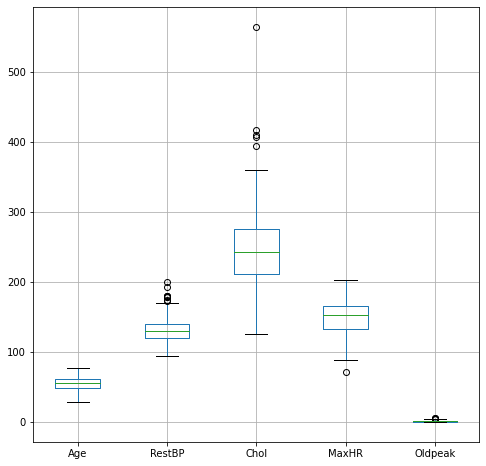

In [ ]:
df_clean.select_dtypes(include='number').boxplot(figsize=(8,8))

*It is possible to have cholesterol up to 1000, so we don't dismiss any values. The other values seem plausible. We check "Oldpeak" separately:*

<AxesSubplot:>

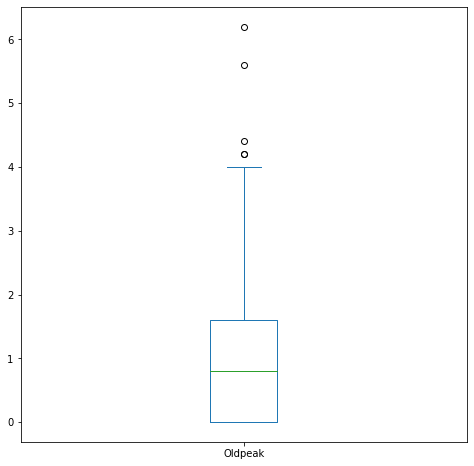

In [ ]:
df_clean['Oldpeak'].plot.box(figsize=(8,8))

*It looks ok*

The response variable that we will try to predict is "AHD", that indicates whether the patient has a heart disease.

Now split the data into the features `X` and the response `y`.

As, sadly, trees in sklearn do not handle categorical features directly, transform `X`'s categorical variables into "dummies". This can be achieved either with panda's `pd.get_dummies(<data>, drop_first=True)` or sklearn's `OneHotEncoder`. Make sure that you keep X in dataframe format, and keep feature/column names.

In [ ]:
X_2 = pd.get_dummies(df_clean.drop(["AHD"],axis=1),drop_first=True)
y_2 = df_clean["AHD"]

Split the data into train and test. Set random_state=40 and leave 20% of the data out for the test set.

In [ ]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,y_2, test_size=20, random_state=40)

### 2.1 Unpruned tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

Begin by fitting a (unpruned) classification tree to the training data, in order to predict whether each patient potentially has AHD, based on his available demographic and medical information. Use either the Gini index or the entropy as a splitting criterion, as you prefer.

In [ ]:
Tree = DecisionTreeClassifier()
Tree.fit(X_2_train,y_2_train)

DecisionTreeClassifier()

Now plot the tree using sklearn's `plot_tree` function

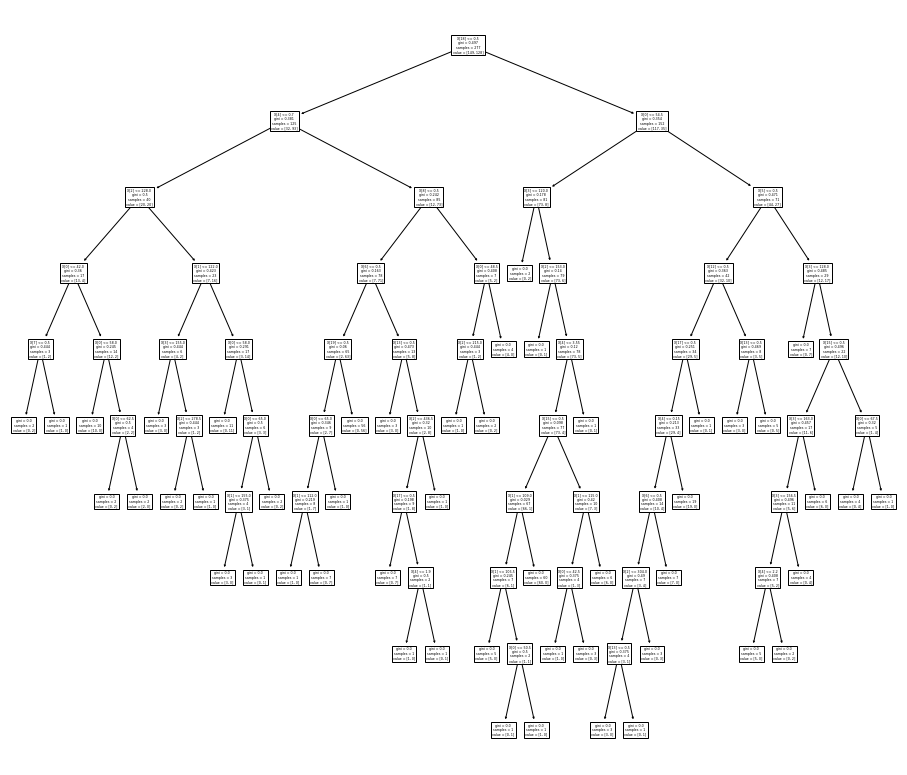

In [ ]:
plt.figure(figsize=(16,14))
plot_tree(Tree)
plt.show()

Could you use only this image to predict the "AHD" variable for the observations left out in the test set?

*Yes, by choosing the corresponding branch from top to bottom*

Now check the model's training and test accuracy (or score). What do you observe and why ?

In [ ]:
print("Train accuracy:", Tree.score(X_2_train,y_2_train))
print("Test accuracy:", Tree.score(X_2_test,y_2_test))

Train accuracy: 1.0
Test accuracy: 0.75


*Unsurprisingly, the test score is lower than the train score. Also, since by default the DecisionTree takes min_samples_split=2, it will split until there are fewer than 2 covariates in each leave, making all leaves pure*

### 2.2. Cost-complexity pruning

Remember that the flexibility of a decision tree can be tuned by pruning it via cost-complexity pruning.

Use cross-validation to select the best cost-complexity hyper-parameter $\alpha$ value. Then, plot the tree coresponding to the best $\alpha$ value.

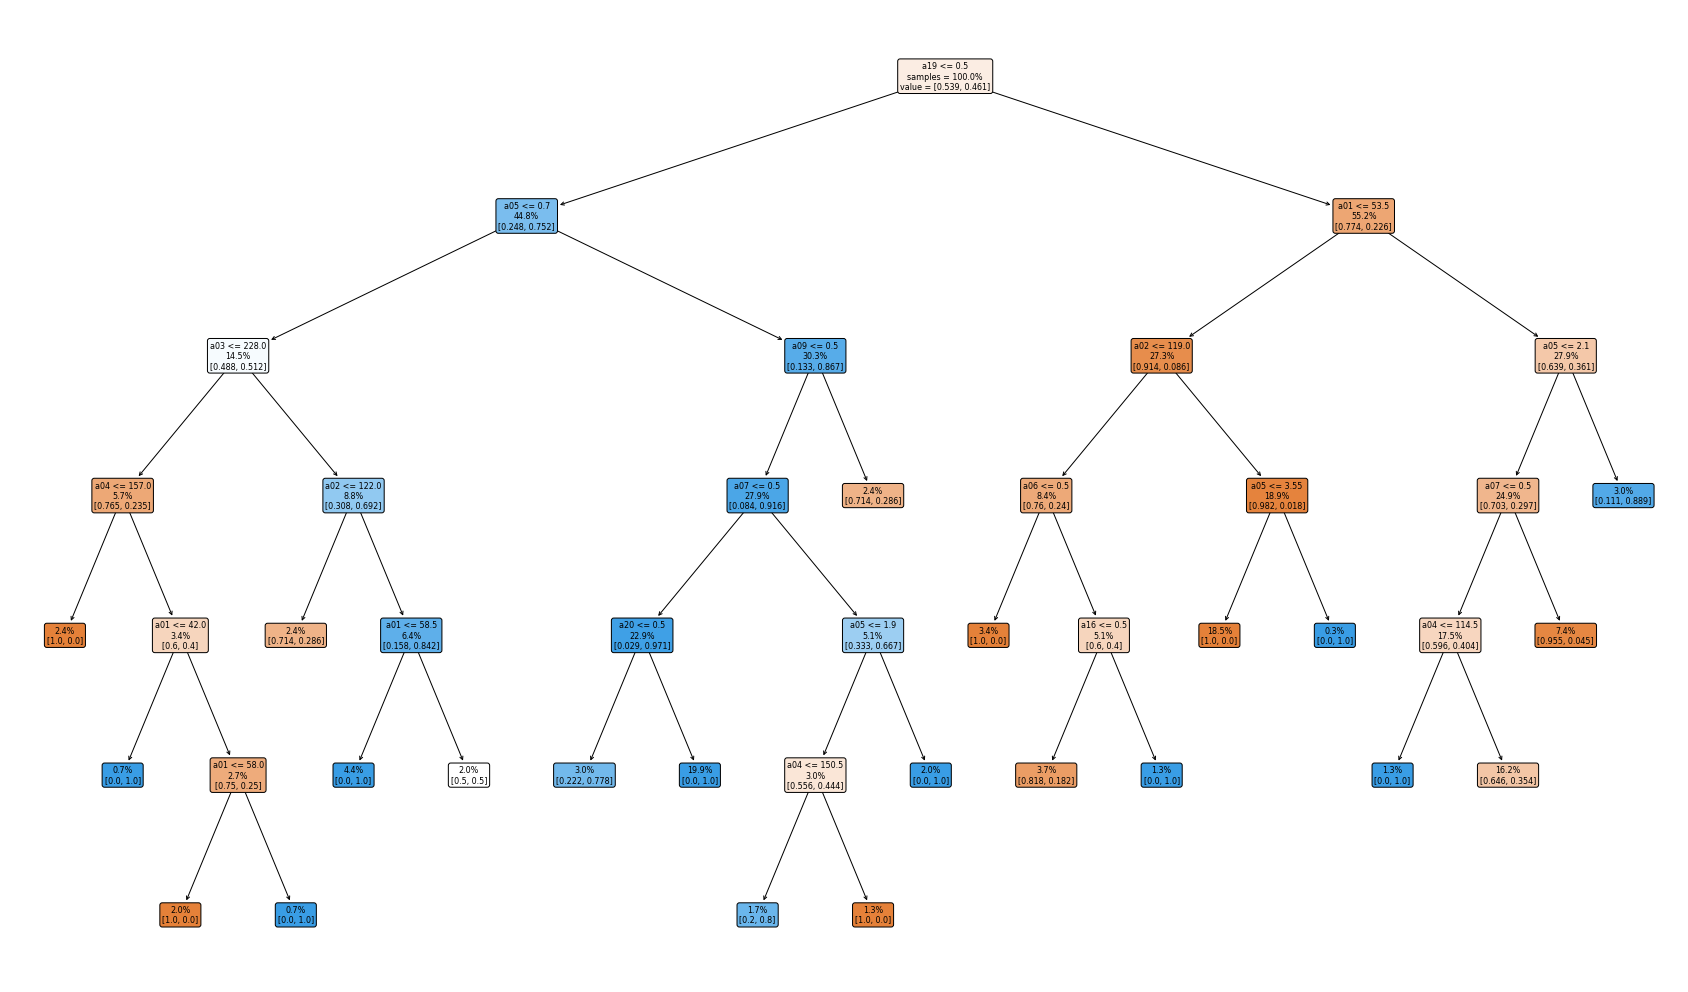

In [ ]:
grid_alphas = np.arange(0,0.05,0.005)
folds = 10

tree_full = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=1, ccp_alpha=0)
path = tree_full.cost_complexity_pruning_path(X_2_train, y_2_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
hyper_parameters = {"ccp_alpha" : grid_alphas}
treeCV = GridSearchCV(estimator=tree_full, param_grid=hyper_parameters, cv=folds)
treeCV.fit(X_2, y_2)
best_alpha = grid_alphas[np.argmin(1-treeCV.cv_results_["mean_test_score"])]
best_tree = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=1, ccp_alpha=best_alpha)
best_tree.fit(X_2,y_2)
plt.figure(figsize=(30,18))
plot_tree(best_tree, feature_names=X.columns.tolist(), impurity=False, label="root",
filled=True, proportion=True, rounded=True, fontsize=8);

## Problem 3 (not to hand in)

Suppose we have independent observations $(x_1,y_1),\dots, (x_n,y_n)$ from $(X,Y)$ with $x_i \in \mathbb R^p$, and $y_i \in \{0,1\}$,  $i = 1, \dots, n$.
Further assume that the conditional distribution of $Y$ given $X= x$ is Bernoulli with success probability denoted as:
  $$ \mathbb P(Y = 1 \mid X = x) = 1 - \mathbb P(Y = 0 \mid X = x) = \sigma(x^\top \beta),$$
where $\sigma: \mathbb R \to [0, 1]$, and
  $$
  \sigma(a) = \dfrac{e^{a}}{1 + e^{a}}, \quad a\in \mathbb R.
$$
Show that the log-likelihood of the parameter vector $\beta\in\mathbb R^p$ is
  $$\ell(\beta) = \sum_{i=1}^n y_i x_i^\top \beta - \log(1 + e^{x_i^\top \beta}).$$

\begin{align*}
l(β)&=f_{Y_i}(y_1,...y_n;β)\\
&=f_{Y_i | X_i}(y_1,...,y_n;β)\cdot f_{X_i}(x_1,...,x_n;β)\\
&=log(f_{Y_i | X_i }(y_1,...,y_n;β))\\
&=log\left(\prod_{i=1}^nf_{Y_i | X_i}(y_i;β)\right)\\
&=\sum_{i=1}^nlog\left(f_{Y_i | X_i}(y_i;β)\right)\\
&=\sum_{i=1}^nlog(σ(x^Tβ))\\
&=\sum_{i=1}^nlog\left(\frac{e^{x_i^Tβ}}{1+e^{x_i^Tβ}}\right)\\
&=\sum_{i=1}^nlog\left(e^{x_i^Tβ}\right)-log(1+e^{x_i^Tβ})\\
&=\sum_{i=1}^n {x_i^Tβ}-log(1+e^{x_i^Tβ})
\end{align*}
Something wrong, don't know how to compute $P(X=x)$